In [2]:
import xgboost as xgb
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
with open('../pickles/train_test_rs.pkl', 'rb') as pickle_in:
    X_train, X_test, y_train, y_test = pickle.load(pickle_in)

In [4]:
#https://xgboost.readthedocs.io/en/latest/get_started.html
param = {'max_depth': 2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)
bst = xgb.train(param, D_train)
# make prediction
filt = 0.5
preds =[ 1 if i > filt else 0 for i in  bst.predict(D_test)]


[17:11:00] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [5]:
metrics.recall_score(y_test, preds)

0.47058823529411764

In [6]:
for max_depth in [2]:
    for l in [0,0.2,1,2]:
        for a in [0,0.2,1,2]:
            param = {'max_depth': max_depth, 'eta':1, 'objective':'binary:logistic', 'alpha':a, 'lambda':l }
            bst = xgb.train(param, D_train)
            filt = 0.5
            preds =[ 1 if i > filt else 0 for i in  bst.predict(D_test)]
            print(metrics.recall_score(y_test, preds), metrics.accuracy_score(y_test, preds), max_depth, l, a)

[17:11:00] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5098039215686274 0.7307692307692307 2 0 0
[17:11:00] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824 0.7727272727272727 2 0 0.2
[17:11:00] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.52

In [7]:
param = {'max_depth': 2, 'eta':1, 'objective':'binary:logistic', 'alpha':0, 'lambda':0 }
param = {'max_depth': max_depth, 'eta':1, 'objective':'binary:logistic', 'alpha':a, 'lambda':l }
bst = xgb.train(param, D_train)
filt = 0.35
preds =[ 1 if i > filt else 0 for i in  bst.predict(D_test)]
print(metrics.recall_score(y_test, preds), metrics.accuracy_score(y_test, preds))

[17:11:01] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6862745098039216 0.7167832167832168


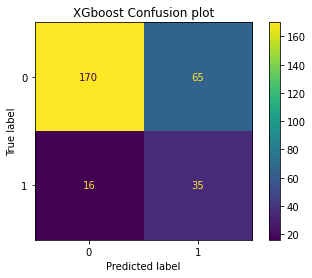

In [8]:
#bst.save_model('../models/xgb.json')
con  = metrics.confusion_matrix(y_test, preds)
metrics.ConfusionMatrixDisplay(con).plot();
plt.title('XGboost Confusion plot')
plt.savefig('../output/xgb.png')

In [9]:
y_test.value_counts()

0    235
1     51
Name: Attrition, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

df2 = pd.read_csv('../data/attrition-formated.csv')
df2.dropna(inplace=True)
df2.drop(columns='EmployeeNumber', inplace=True)
with open('../pickles/sc.pkl', 'rb') as pickle_in:
    sc = pickle.load(pickle_in)
df2 = pd.get_dummies(df2, columns = ['EducationField'] )
X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns=['Attrition']), df2['Attrition'], stratify = df2['Attrition'])
X_train_df = pd.DataFrame(X_train)
X_train_df['Attrition'] = y_train

recall = 0 
acc = 0

rs = X_train_df[X_train_df['Attrition'] == 1].sample(500, replace = True)
X = pd.concat([X_train_df, rs])
y = X['Attrition']
X = X.drop(columns=['Attrition'])
X_train = sc.fit_transform(rs.drop(columns=['Attrition']))

D = xgb.DMatrix(X_train, label = y_train)
X.shape, y.shape

((1357, 35), (1357,))

In [11]:
recall = 0 
acc = 0
sample_rate = 0
for i in range(50, 1000, 50): 
    rs = X_train_df[X_train_df['Attrition'] == 1].sample(i, replace = True)
    X = pd.concat([X_train_df, rs])
    y = X['Attrition']
    X = X.drop(columns=['Attrition'])
    X_train = sc.fit_transform(rs.drop(columns=['Attrition']))

    D = xgb.DMatrix(X, label = y)
    bst = xgb.train(param, D)
    evalu = xgb.DMatrix(X_test)
    preds = [ 1 if i > filt else 0 for i in  bst.predict(evalu)]
    
    

    if (metrics.recall_score(y_test,preds) > recall) and (metrics.accuracy_score(y_test,preds) >= .68):
        print(recall)
        recall = metrics.recall_score(y_test, preds)
        acc = metrics.accuracy_score(y_test,preds)
        sample_rate = i


[17:11:02] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0
[17:11:02] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
[17:11:02] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:02] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/

In [12]:
recall, acc, sample_rate

(0.7450980392156863, 0.7342657342657343, 400)